<a href="https://colab.research.google.com/github/soerenml/colab/blob/master/structured_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict housing prices

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

print("TF version: {}".format(tf.__version__))

TF version: 2.2.0


In [0]:
url = 'https://raw.githubusercontent.com/plotly/datasets/master/auto-mpg.csv'
dataset = pd.read_csv(url, error_bad_lines=False)

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    396 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model-year    398 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 21.9 KB


In [0]:
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70


In [0]:
dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year
count,398.000000,398.000000,398.000000,396.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.189394,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.402030,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [0]:
dataset.isna().sum()
dataset = dataset.dropna()

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
val_dataset = dataset.drop(train_dataset.index)

features_train = train_dataset.drop(['mpg'], axis=1)
target_train = train_dataset['mpg']

features_val = val_dataset.drop(['mpg'], axis=1)
target_val = val_dataset['mpg']

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     398 non-null    int64  
 1   displacement  398 non-null    float64
 2   horsepower    396 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model-year    398 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 18.8 KB


# Building the simplest model possible

## Load data

In [0]:
from tensorflow.data import Dataset

def input_function(batch_size):
  tf_dataset = Dataset.from_tensor_slices((features_train, target_train))
  tf_dataset = tf_dataset.shuffle(len(dataset)).batch(batch_size)
  return tf_dataset

## Train the model

In [0]:
from tensorflow.keras import layers

n_features = len(features.keys())

model = keras.Sequential(
    [
     layers.Dense(64, activation='relu', input_shape=[n_features]),
     layers.Dense(64, activation='relu'),
     layers.Dense(1)
     ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.summary()

history = model.fit(
    input_function(batch_size=10),
    epochs=30)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_130 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
32/32 [==============================] - 0s 1ms/step - loss: 2707.6992 - mae: 23.9803 - mse: 2707.6992
Epoch 2/30
32/32 [==============================] - 0s 1ms/step - loss: 1059.7318 - mae: 27.1603 - mse: 1059.7318
Epoch 3/30
32/32 [==============================] - 0s 1ms/step - loss: 758.1152 - mae: 19.1082 - mse: 758.1152
Epoch 4/30
32/32 [=======================

# Functional API with feature columns

Let's create some more meaningful features.

In [0]:
from tensorflow import feature_column

numeric_features = ["cylinders", "displacement", "horsepower",
                    "weight",	"acceleration",	"model-year"]

feature_columns = []

for header in numeric_features:
   feature_columns.append(feature_column.numeric_column(header))

print(feature_columns)

[NumericColumn(key='cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='model-year', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [0]:
input_layers = {
    "cylinders": tf.keras.layers.Input(name="cylinders", shape=(), dtype=tf.float32)
    }
input_layers.update({
    "displacement": tf.keras.layers.Input(name="displacement", shape=(), dtype=tf.float32)
    })
input_layers.update({
    "horsepower": tf.keras.layers.Input(name="horsepower", shape=(), dtype=tf.float32)
    })
input_layers.update({
    "weight": tf.keras.layers.Input(name="weight", shape=(), dtype=tf.float32)
    })
input_layers.update({
    "acceleration": tf.keras.layers.Input(name="acceleration", shape=(), dtype=tf.float32)
    })
input_layers.update({
    "model-year": tf.keras.layers.Input(name="model-year", shape=(), dtype=tf.float32)
    })

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
acceleration (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
cylinders (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
displacement (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
horsepower (InputLayer)         [(None,)]            0                                            
___________________________________________________________________________________________

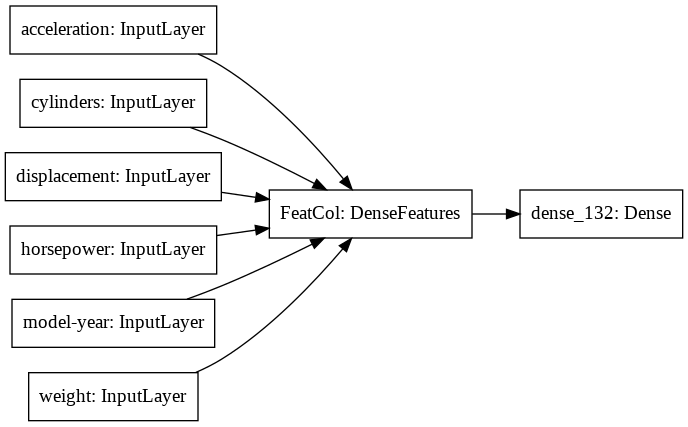

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, name='FeatCol')(input_layers)
output = tf.keras.layers.Dense(1)(feature_layer)
model = tf.keras.Model(input_layers, output)

model.summary()

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mean_squared_error'])
tf.keras.utils.plot_model(model, 'MPG.png', show_shapes=False, rankdir='LR')

In [0]:
history = model.fit(
    input_function(batch_size=10),
    epochs=30)

Epoch 1/30


AssertionError: ignored

In [0]:

# Bucketized cols.
age = feature_column.numeric_column("age")
feature_columns.append(feature_column.bucketized_column(age, boundaries=[3, 4, 5, 6, 8]))

n_siblings_spouses = feature_column.numeric_column("n_siblings_spouses")
feature_columns.append(feature_column.bucketized_column(n_siblings_spouses, boundaries=[0, 1, 3]))

# Categorical columns.
ship_class = feature_column.categorical_column_with_vocabulary_list(
    'class', ["First", "Second", "Third"])
feature_columns.append(feature_column.indicator_column(ship_class))

embark_town = feature_column.categorical_column_with_vocabulary_list(
    'embark_town', ["Southampton", "Queenstown", "Cherbourg", "unknown"])
feature_columns.append(feature_column.indicator_column(embark_town))

sex = feature_column.categorical_column_with_vocabulary_list(
    'sex', ["male", "female"])
feature_columns.append(feature_column.indicator_column(sex))